# Support Vector Machines (SVM)

A *Support Vector Machine (SVM)* is capable of performing linear or non-linear classification, regression, and even outlier detection. SVMs are particularly well suited for classification of complex *small- or medium-sized datasets.*
<br>
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear SVM Classification

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1) # setosa = 0, versicolor = 1
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

In [3]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):

    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

Saving figure large_margin_classification_plot


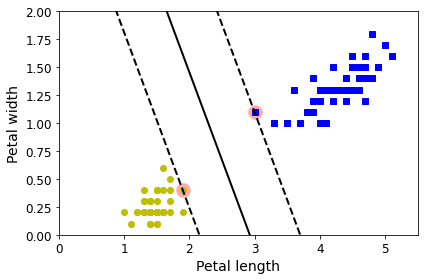

In [4]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plot_svc_decision_boundary(svm_clf, 0, 5.5)

save_fig("large_margin_classification_plot")
plt.show()

The decision boundary not only separates the two classes but also stays as far away from the closest training instances as possible. This is called **large margin classification.**<br>

**Support vectors** are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier.

#### Hard Margin Classification.
If we strictly impose that all instances must be off the street and on the right side, this is called *hard margin classification*.

There are two main issues with hard margin classification:
1. it only works when the data is linearly separable
2. it is sensitive to outliers.

#### Soft Margin Classification
The objective is to find a good balance between keeping the street as large as possible and limiting the *margin violations*. This is called *soft margin classification*.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

iris = datasets.load_iris()

X = iris['data'][:,(2,3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # iris virginica

svm_clf = Pipeline([
    ('std_scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [6]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

### Large margin vs fewer margin violations

C is one of the hyperparameters.

Now let's generate the graph comparing different regularization settings:

In [7]:
scaler = StandardScaler()

svm_clf1 = LinearSVC(C=1, loss='hinge', random_state=42)
svm_clf2 = LinearSVC(C=100, loss='hinge', random_state=42)

# C=1
scaled_svm_clf1 = Pipeline([
    ('std_scaler', scaler),
    ('linear_svc', svm_clf1)
])

# C=100
scaled_svm_clf2 = Pipeline([
    ('std_scaler', scaler),
    ('linear_svc', svm_clf2)
])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/Users/sankalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [8]:
# Convert to unscaled parameters *!imp*

b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1 # converts 0 to -1, 1 to +1

support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


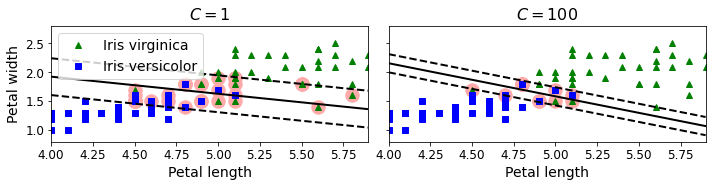

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([4, 5.9, 0.8, 2.8])
plt.legend(loc="upper left", fontsize=14)


plt.sca(axes[1])
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf2, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.axis([4, 5.9, 0.8, 2.8])
save_fig("regularization_plot")
plt.show()

from the above plots it is clear that
* C with a lower value will generalize better but will have more margin violations. 

Its usually better to have fewer margin violations. If SVM model is overfitting, you can try regularizing it by reducing C.

## Nonlinear SVM Classification

#### Polynomial Kernel

##### Kernel Trick
What kernel trick does for us is to offer a more efficient and less expensive way to transform data into higher dimensions.It allows us to operate in the original feature space without computing the coordinates of the data in a higher dimensional space.

Let’s look at an example:
$$ x = (x_1, x_2, x_3)^T $$
$$ y = (y_1, y_2, y_3)^T $$

Here x and y are two data points in 3 dimensions. Let’s assume that we need to map x and y to 9-dimensional space. 
We need to do the following calculations to get the final result, which is just a scalar. The computational complexity, in this case, is O(n²).

$$ \phi(x) = (x_1^2, x_1x_2, x_1x_3, x_2x_1, x_2^2, x_2x_3, x_3x_1, x_3x_2, x_3^2) $$
$$ \phi(y) = (y_1^2, y_1y_2, y_1y_3, y_2y_1, y_2^2, y_2y_3, y_3y_1, y_3y_2, y_3^2) $$

$$ \phi(x)^T\phi(y) = \sum_{(i,j=1)}^3 x_ix_jy_iy_j $$


However, if we use the kernel function, which is denoted as k(x, y), instead of doing the complicated computations in the 9-dimensional space, we reach the same result within the 3-dimensional space by calculating the dot product of x -transpose and y. The computational complexity, in this case, is O(n).

$$ k(x,y) = (x^Ty)^2 = (x_1y_1 + x_2y_2 + x_3y_3)^2 =  \sum_{(i,j=1)}^3 x_ix_jy_iy_j $$ 

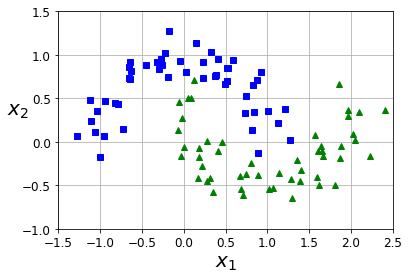

In [27]:
from sklearn.datasets import make_moons

# the datapoints are shaped as two interleaving half circles
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [38]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/Users/sankalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

Saving figure moons_polynomial_svc_plot


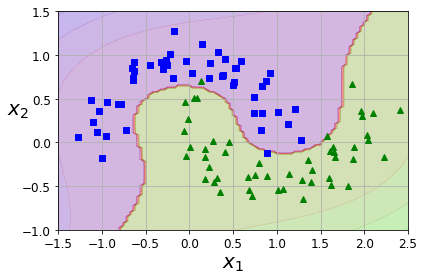

In [47]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

In [49]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

In [50]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

Saving figure moons_kernelized_polynomial_svc_plot


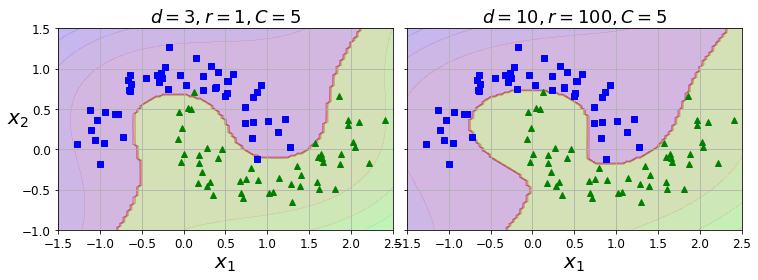

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

If the model is overfitting, try reducing the polynomial degree. 
**coef0** controls how much the model is influenced by high-degree polynomials vs low-degree polynomials.

*NOTE:* A common approach to finding the right hyperparameter values is to use a grid search.

#### Gaussian RBF Kernel

Saving figure moons_rbf_svc_plot


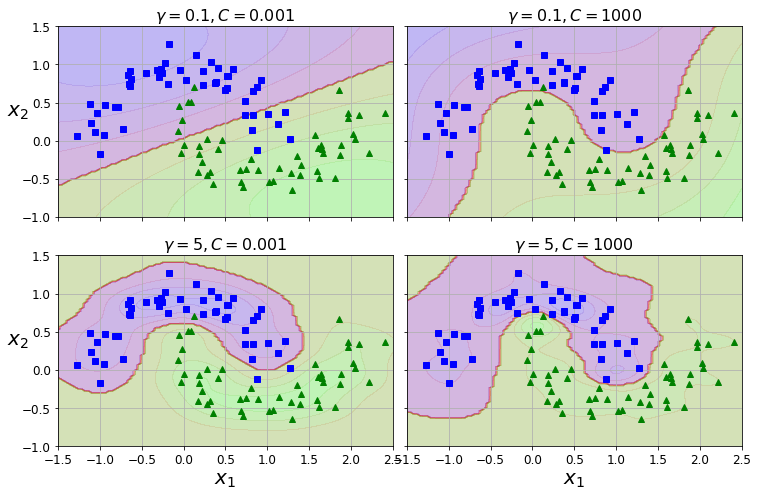

In [83]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
c1, c2 = 0.001, 1000

hyperparams = (gamma1, c1), (gamma1, c2), (gamma2, c1), (gamma2, c2)

svm_clfs = []

for i, (gamma, c) in enumerate(hyperparams):
    
    grbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=c))
    ])
    
    grbf_kernel_svm_clf.fit(X, y)
    
    svm_clfs.append(grbf_kernel_svm_clf)
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):

    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clfs[i], [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    
    gamma, c = hyperparams[i]
    plt.title(r"$\gamma={}, C={}$".format(gamma, c), fontsize=16)
    if i in (0,1):
        plt.xlabel('')
    if i in (1,3):
        plt.ylabel('')
        
save_fig("moons_rbf_svc_plot")
plt.show()

Increasing $\gamma$ makes the bell-shaped curve narrower. As a result, each instance's range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances.

$\gamma$ acts like a regularization hyperparameter. If your model is overfitting, you should reduce it; if it is underfitting, you should increase it.

###### Classification Summary:
* Always try the linear kernel first (as linearSVC is much faster than SVC(kernel='linear'); especially if the training set is very large or if it has plenty of features.
* If training set is not too large, you should also try Gaussian RBF kernel, it works well in most cases.

###### Computational Complexity
* The linearSVC class is based on *liblinear* library.
* The SVC class is based on *libsvm* library.